# Distributed Computing with dask

In this portion of the course, we'll explore distributed computing with a Python library called `dask`.

Dask is a library designed to help facilitate (a) the manipulation of very large datasets, and (b) the distribution of computation across lots of cores or physical computers. It is very similar to Apache Spark in the functionality it provides, but it is tightly integrated into `numpy` and `pandas`, making it *much* easier to learn than spark for users of those libraries (there's no java dependencies, for example, and the syntax is what you already know!).

## What can dask do for me?

To get a sense of why dask is so nice, let's begin with a demonstration. Suppose I have a pretty big dataset (say, [an 100GB CSV of all drug shipments in the United States from 2006 to 2014](https://www.dropbox.com/s/oiv3k3sfwiviup5/all_prescriptions.csv?dl=0)). This data is too large for me to load into ram on my laptop directly, so if I were to work with it on my own, I'd do so by [chunking the data by hand](20_big_data_strategies.ipynb). But using dask, I can do the following:

In [1]:
# Standard setups
import pandas as pd
import numpy as np
import os

pd.set_option("mode.copy_on_write", True)

os.chdir("/users/nce8/dropbox/MIDS/MIDS_Data_Prep/arcos")

In [2]:
# Here we start up a dask cluster.
# This creates a set of "workers".
# In this case, these workers are all on
# my computer, but if we wanted to connect
# to a cluster, we'd just past an IP address
# to `Client()`.

# You can see how many cores your computer
# has using `os.cpu_count()` in the `os` library.

# Note you may get some warnings about
# Python wanting to accept incoming
# connections from your firewall.
# You need to approve those
# so workers can talk to one another.

# DON'T keep rerunning this line of code.

import os

print(f"I have {os.cpu_count()} logical cores.")

from dask.distributed import Client

client = Client()
client

I have 10 logical cores.


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57778,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 64.00 GiB
Comm: tcp://127.0.0.1:57791,Total threads: 2
Dashboard: http://127.0.0.1:57792/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:57781,


In [3]:
# Load Dask
import dask.dataframe as dd

In [ ]:
# ARCOS Data on all drug shipments in US from 2006 to 2014
# I was unable to get this data
# into my repo, but you can find the relevant data here:
# https://www.washingtonpost.com/national/2019/07/18/how-download-use-dea-pain-pills-database/
# This site includes several downloadable opioid samples.
#
# This, in particular, is the `arcos_all.zip` file you get from the
# bullet point "If you want to download the full data set released
# by the Ohio federal court, click here." (I just renamed it before using it here)
# Link:
# https://gfx-data.news-engineering.aws.wapo.pub/ne-static/arcos/v2/bulk/arcos_all.zip

# If you're really internet constrained, here's a two-year sample of just oxy and hydrocodone:
# https://www.dropbox.com/scl/fi/8dut9svmbmer83p2qduts/arcos_2011_2012.tsv.zip?rlkey=l3hg46gzo7xgtzd6dg1higf6g&dl=0

# Note that while pandas can read compressed files like this .tsv.gz,
# file, dask cannot. So if you want to do this at home,
# you have to decompress the data.

df = dd.read_csv(
    "all_prescriptions.csv",
    dtype={
        "ACTION_INDICATOR": "object",
        "ORDER_FORM_NO": "object",
        "REPORTER_ADDRESS2": "object",
        "REPORTER_ADDL_CO_INFO": "object",
        "BUYER_ADDL_CO_INFO": "object",
        "BUYER_ADDRESS2": "object",
        "NDC_NO": "object",
        "UNIT": "object",
        "STRENGTH": "float64",
        "BUYER_ZIP": "object",
        "DRUG_CODE": "object",
        "MME_Conversion_Factor": "object",
        "QUANTITY": "object",
        "TRANSACTION_DATE": "float64",
        "TRANSACTION_ID": "float64",
        "dos_str": "object",
    },
)

In [5]:
# Extract year
df["date"] = dd.to_datetime(df.TRANSACTION_DATE, format="%m%d%Y")
df["year"] = df.date.dt.year
df["MME_Conversion_Factor"] = dd.to_numeric(
    df["MME_Conversion_Factor"], errors="coerce"
)
# Make an estimate of total morphine equivalent shipments
df["morphine_equivalent_g"] = (df["CALC_BASE_WT_IN_GM"]) * df["MME_Conversion_Factor"]

# Drop extra vars
df = df[["year", "morphine_equivalent_g", "BUYER_STATE", "BUYER_COUNTY"]]

# Collapse to total shipments to each county in each year.
collapsed = df.groupby(
    ["year", "BUYER_STATE", "BUYER_COUNTY"]
).morphine_equivalent_g.sum()
collapsed

Dask Series Structure:
npartitions=1
    Float64
        ...
Dask Name: sum, 17 expressions
Expr=Sum(frame=(Assign(frame=Assign(frame=Assign(frame=Assign(frame=ReadCSV(d205952)))))[['year', 'morphine_equivalent_g', 'BUYER_STATE', 'BUYER_COUNTY']])[['year', 'morphine_equivalent_g', 'BUYER_STATE', 'BUYER_COUNTY']], observed=False, chunk_kwargs={'numeric_only': False}, aggregate_kwargs={'numeric_only': False}, _slice='morphine_equivalent_g')

In [6]:
%%time
final = collapsed.compute()
final.sample(10)


2024-11-07 15:58:51,947 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ea40ef4a056c628e67e00bb2e66ffa9a initialized by task ('shuffle-transfer-ea40ef4a056c628e67e00bb2e66ffa9a', 323) executed on worker tcp://127.0.0.1:57793
2024-11-07 16:01:23,275 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ea40ef4a056c628e67e00bb2e66ffa9a deactivated due to stimulus 'task-finished-1731013283.2746298'


CPU times: user 8.19 s, sys: 1.92 s, total: 10.1 s
Wall time: 2min 33s


year    BUYER_STATE  BUYER_COUNTY
2007.0  MS           YALOBUSHA        1369.835225
2008.0  MS           TATE             7579.680394
2014.0  SC           ABBEVILLE         5095.21593
2009.0  GA           LANIER           1839.825007
2007.0  TN           HENRY           23596.079639
2010.0  NE           MADISON          5478.756424
        SD           BROOKINGS        3493.127165
2014.0  SD           KINGSBURY         576.921142
2009.0  SC           LEXINGTON       62507.822757
2006.0  NC           CHATHAM          8251.795136
Name: morphine_equivalent_g, dtype: Float64

Voila! I get back my thinned-out dataset with the new variable I wanted. And it only took about 2.5 minutes.

So let's discuss what just happened.

1. First, when I ran Client(), dask started up a set of 5 new python processes on my computer (called "workers") it could call on for help, each of which had access to two threads (so dask has access to 10 threads total). These processes fully independent agents that could be running on different machines in a true cluster (though in this case, they're all on my laptop).
2. dask collected all the instructions I gave it for reading in the file, generating a new column, deleting extra columns, and grouping. **But it didn't actually execute any code**. That's why when I typed `collapsed`, what I got back was a dataframe with structure but no data—dask had figured out roughly what the result of my commands would look like, but hadn't actually computed the result.
3. Then, when I ran `collapsed.compute()`, dask came up with a set of assignments it could give to its workers to get me what I wanted and it started to actually compute the table I requested. In particular:
    - each thread loaded a chunk of the data, did the observation-level manipulations I wanted, and dropped extra columns.
    - then to execute the groupby, it then collapses the data in each chunk, passes those collapsed chunks to a common worker who then re-collapses them further, then gathers them again under (potentially) another worker and collapses further until all the data had been collapsed.
    - Finally, after all the data had been collapsed, the data was passed back to me (the client session) as the variable `final`.

And it did it all in under 5 minutes!


## "Um... why didn't you tell us about this before?" I hear you say...

"This sure seems like this is easier than [chunking by hand](20_big_data_strategies)!!!!"

The answer is that these distributed computing tools are often very fragile and opaque, and it's easy to get in trouble using them, and hard to figure out why if you don't understand the underlying principles that govern their operation.  

This example was carefully chosen. I used only manipulations that dask is really good at, and I have the experience to implement them in a way that works. But do what I did above in slightly different ways, and chaos would ensue. Ok, not chaos. But your computer would probably crash. 

The biggest challenge in using a tool like dask or spark (they operate on the same principles -- more on that below) is that to prevent crashes, you have to understand how and why dask is chunking your data. And the best way to do that is to get experience chunking by hand. 

For example, one of the key features of distributed computing is that they don't run code as soon as you type it. Instead, they just keep track of what you want and wait until you run `.compute()` to actually execute your code. Why? Because if dask had run each command as I entered it and passed the result back to me, it would have crashed my computer. 

Recall that the whole reason we're using dask is precisely because we knew that loading the whole dataset at once would take up more memory than I have available. It's only because we only loaded a few chunks of the data at a time, thinned out those chunks by dropping variables, and then collapsed by county-state-year that we ended up with a dataset that was small enough that it would fit in memory.

In other words, this only worked because I knew that the steps after the initial load would reduce the size of the dataset enough that when I ran `.compute()`, the result I got back would be small enough to fit in memory. Had I just run:

```python
df = dd.read_csv(
    "arcos_all_washpost_2006_2012.tsv",
    sep="\t",
    dtype={
        "ACTION_INDICATOR": "object",
        "ORDER_FORM_NO": "object",
        "REPORTER_ADDRESS2": "object",
        "REPORTER_ADDL_CO_INFO": "object",
        "BUYER_ADDL_CO_INFO": "object",
        "BUYER_ADDRESS2": "object",
        "NDC_NO": "object",
        "UNIT": "object",
    },
)
df.compute()
```

dask would have tried to hand the full dataset back to me, and my computer would have crashed, just as it would have had I tried to read the full dataset with `pandas`. 

So understanding the *intuition* of chunking is a prerequisite to using these tools effectively. 

## Vocabulary

Now that we've seen this example, let's formally introduce some distributed computing vocabulary:

- **Lazy Evaluation** (also sometimes called "delayed execution"): The practice of not executing code as soon as you type it, but rather accumulating a set of requests, then executing them when instructed. This allows distributing computing systems to optimize how they move around data and get things done, and ensures that you don't end up with the system trying to shove a massive dataset into ram that's too small. 
- **Client**: The central process (here, Python process) where code is being entered.
- **Workers**: Other processes that are assigned work, and which eventually pass results back to the client. 
- **Scheduler**: The part of the system that manages the assignment of tasks to different workers.
- **map-reduce**: The name for the process of distributing sub-problems to workers (`map`), then processing them in a way that allows the results to be recombined (`reduce`). `map`s and `reduce`s are kind of the building blocks of distributed systems, though when working with dask you won't usually have to manage the assignment or recombination of tasks yourself (they're happening behind the scenes). 

## Let's Learn More dask!

OK, now that we have the basic idea of dask in hand, please watch the following set of seven short videos on dask, then come back here and we can talk some more!

[Dask Tutorial from Coiled—7 videos, about 1 hour in total](https://www.youtube.com/watch?v=z18qjLu-Mw4&list=PLeDTMczuyDQ8S73cdc0PrnTO80kfzpgz2)


## There is no magic here


As noted in that video, one of the very nice things about dask (and one of the reasons it's been able to offer so much functionality so quickly) is that it really is just an extension of `numpy` and `pandas`. There is no magic here. 

For example, suppose we wanted to find the largest number of pills in a single shipment in our ARCOS dataset, but we don't have the memory to load the whole dataset into memory at once. How would we get that number? Probably by doing something like:

In [7]:
import pandas as pd
import numpy as np
import os

os.chdir("/users/nce8/dropbox/MIDS/MIDS_Data_Prep/arcos")

# Create an interator of the data so
# it doesn't all load at once
df = pd.read_csv(
    "all_prescriptions.csv",
    iterator=True,
    chunksize=250_000,
    usecols=["DOSAGE_UNIT", "Measure"],
)


# Find the max from each chunk
max_candidates = list()
for chunk in df:
    # Subset for pill shipments
    chunk = chunk[chunk["Measure"] == "TAB"]

    # Find largest in this chunk
    max_candidates.append(chunk["DOSAGE_UNIT"].max())

# Now gather those candidates together and
# find the maximum of all the chunk maximums.
np.max(max_candidates)

np.float64(3115000.0)

Wow... that is a LOT of pills!

Now suppose we asked dask to do the same thing: 

In [8]:
df = dd.read_csv(
    "all_prescriptions.csv",
    dtype={
        "ACTION_INDICATOR": "object",
        "ORDER_FORM_NO": "object",
        "REPORTER_ADDRESS2": "object",
        "REPORTER_ADDL_CO_INFO": "object",
        "BUYER_ADDL_CO_INFO": "object",
        "BUYER_ADDRESS2": "object",
        "NDC_NO": "object",
        "UNIT": "object",
    },
)

df = df[df["Measure"] == "TAB"]
max_shipment = df["DOSAGE_UNIT"].max()
max_shipment.compute()

np.float64(3115000.0)

What dask is actually doing is exactly what you just did! It reads in chunks of the dataset, calculates `morphine_equivalent_g` for each chunk, then calculates the maximum value for that chunk. Then it gathers all those maximium values, and finds the maximum of all those chunk maximums. The only difference is that it loads and evaluations chunks in parallel, and it's parallel workers then have to pass their maximum value candidates to a central node for the final evaluation. 

Moreover, when I said that's exactly what dask did, I don't just mean that you and dask are doing the same thing *in principle*—dask is built on pandas, so it really is calling `pd.read_csv`, and the `pandas` `.max()` method, just like you. 

Dask's developers were smart, and didn't want to reinvent the wheel—they just created a package full or recipes for using numpy/pandas to (a) divide tasks into smaller pieces it can distribute to different workers  (map), and to (b) recombine the results of sub-problems to give you a single answer (reduce). 

But those recipes are just made of the pandas and numpy code you know and love. Or at least tolerate begrudingly. 

## Lazy Evaluation

You've already seen this above, but I think this is THE concept that is central to understanding not just dask, but **any** distributed computing platform (e.g. Spark, Hadoop, etc.), so I really want to drive home the importance of this concept.

The fact that you can give dask a handful of commands *and then* tell it to execute them is at the absolute core of what makes it effective. The more commands you can give dask up front, the more it can optimize how it distributes that work—and how it moves data between different computers. Moving data between processes and between computers is *by far* the slowest part of distributed computing, so the more dask can minimize those transfers, the faster it will be. 

Moreover, lazy evaluation is how you protect yourself from crashing your computer. Consider the following code:

```python
df = dd.read_csv(
    "all_prescriptions.csv",
    dtype={
        "ACTION_INDICATOR": "object",
        "ORDER_FORM_NO": "object",
        "REPORTER_ADDRESS2": "object",
        "REPORTER_ADDL_CO_INFO": "object",
        "BUYER_ADDL_CO_INFO": "object",
        "BUYER_ADDRESS2": "object",
        "NDC_NO": "object",
        "UNIT": "object",
    },
)

df = df[df['Measure'] == "TAB"] 
df.compute()
```

If `dd.read_csv()` executed immediately and tried to load all the data and pass it back to you before subsetting, it'd crash your computer! After all, if you could load it all at once, we probably wouldn't be using dask, would we? It's only because dask knows you want to load each chunk then subset it before collecting all those pieces that this code works.



### Visualizing Task Graphs

You can actually see how your computer is developing a plan with the `.dask` method, which you can run on any dask object before you've run `.compute()`. For a big manipulation, however, it's... insanely big, so I won't print it out here. But you can also see a "task graph" that shows this plan visually with `.visualize()`. Note `visualize()` requires you install `python-graphviz` with conda first. You can find more examples [here if you'd like.](https://docs.dask.org/en/stable/graphviz.html)



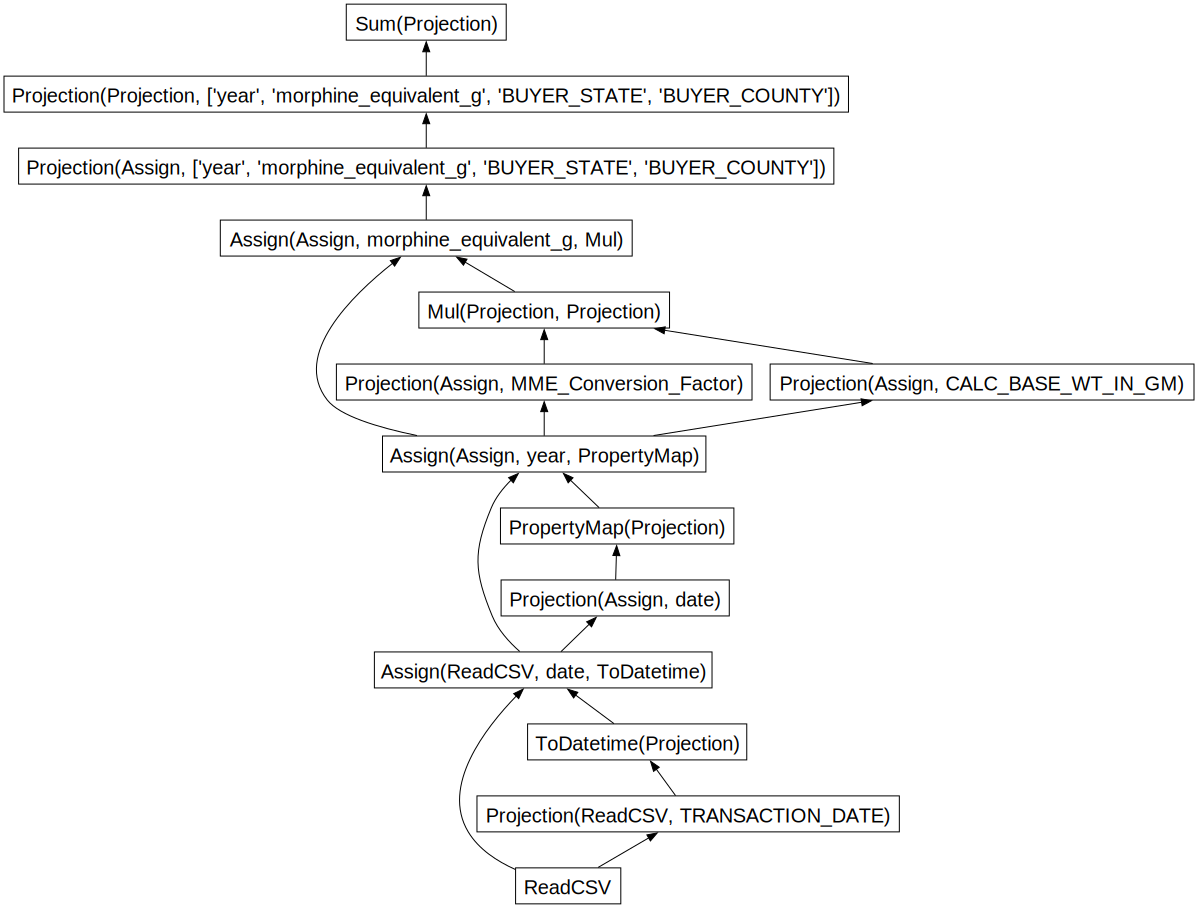

In [16]:
df = dd.read_csv(
    "all_prescriptions.csv",
    dtype={
        "ACTION_INDICATOR": "object",
        "ORDER_FORM_NO": "object",
        "REPORTER_ADDRESS2": "object",
        "REPORTER_ADDL_CO_INFO": "object",
        "BUYER_ADDL_CO_INFO": "object",
        "BUYER_ADDRESS2": "object",
        "NDC_NO": "object",
        "UNIT": "object",
    },
)

# Extract year
df["date"] = dd.to_datetime(df.TRANSACTION_DATE, format="%m%d%Y")
df["year"] = df.date.dt.year

# Make an estimate of total morphine equivalent shipments
df["morphine_equivalent_g"] = (df["CALC_BASE_WT_IN_GM"]) * df["MME_Conversion_Factor"]

# Drop extra vars
df = df[["year", "morphine_equivalent_g", "BUYER_STATE", "BUYER_COUNTY"]]

# Collapse to total shipments to each county in each year.
collapsed = df.groupby(
    ["year", "BUYER_STATE", "BUYER_COUNTY"]
).morphine_equivalent_g.sum()
collapsed.visualize()

## dask versus Spark / PySpark

Dask is something of a late-comer to the distributed computing game. Before its rise, the most popular platforms were Hadoop and Spark (spark is basically "Hadoop v2.0"). So... how does dask compare to these? Or more specifically, how does dask compare to Spark (since no one uses Hadoop anymore) and the various Python libraries for using Spark (e.g. PySpark and koalas)?

In terms of functionality, dask and Spark basically do the same things. Both are tools for distributed computing across many computers, and conceptually they work in basically the same ways:  

- Both offer both low-level tools (things like `map`/`filter` in pyspark, and `delayed` in dask) as well as higher-level data structures (`spark` has `spark dataframes`, dask has `dask arrays`; `spark` has RDDs, dask has `dask arrays`).
- Both are fault tolerant (if one machine in your cluster dies, the system knows what the machine that died was doing and can assign it to another cluster).
- Both make use of delayed execution / lazy evaluation to allow the system to develop efficient plans for completing a computation efficiently.
- Both can be run on your own computer, or on a cluster of lots of computers.

**The huge difference, though, is that dask lets you write code with the pandas syntax you already know.** Seriously. There are lots of little "under the hood" things, but from the perspective of an applied Data Scientist, that's the big one: it's just a version of pandas.

Moreover, as we'll see in [later lessons](cloud_dask.ipynb), dask is also insanely easy to setup on a distributed cluster, making it not only easier to use than Spark for a pandas user, but generally also much easier to get up and running (at least in my experience).

Spark, by contrast, is a stand-alone system. It's built to run on Java virtual machines, and Spark itself is written in a language called Scala. It is not a tool for pandas users per se, and so it has its own syntax for manipulating datasets that is distinct from that of `numpy` and `pandas`. 

**A Note on Koalas:** in the last couple years, there have been inroads in implementing the pandas API on top of spark—check out [koalas](https://koalas.readthedocs.io/en/latest/getting_started/10min.html) project if you're at a place that uses spark! But, as usual, my preference is to hew close to tried and trusted tools.

As for which is more popular, as is so often the case with software, it depends on where you're working. In this class, I've decided to teach dask because you don't have to learn a new syntax, so you can instead just focus on learning how distributed computing works. But if you get a job someday that requires you to work with Spark, don't panic -- you'll find that all the concepts you've learned for using dask also apply to Spark—you'll just have to learn some new syntax.

And as for performance, it probably depends on the workload, but I've yet to see anything that suggests dask compute times are slower than Spark compute times. Case studies are always tricky since performance depends on the exact work being done, but here's one [case study comparison of performance](https://arxiv.org/abs/1907.13030) that puts dask just a little ahead. And I've heard reports of dask beating Spark by 40x in another project. So personally, I think dask is a no-brainer if you aren't working at a company that it is already using spark: it will take **much** less of your time setup and use, and it should at least run about even with Spark.

The only exceptions are some specific use cases, like network analysis, where Spark has some libraries that dask does not. For more on these types of issues, check out this [conceptual comparison to Spark](https://docs.dask.org/en/latest/spark.html).

## What else can dask do?

At this point, we've mostly emphasized what dask can do in terms of the data wrangling of dataframes. However, dask has a number of additional functionalities to be aware of:

- Working with dask arrays: dask has a parallelized version of numpy arrays
- Parallelizing arbitrary functions: you can write your own parallelized functions with `delayed`
- Distributed machine learning: dask has parallelized SOME machine learning methods in [dask-ml](https://dask-ml.readthedocs.io/en/latest/)
- dask can be used with different tools for parallelization other than `distributed` (for example, it can do some parallelism through multi-threading). However... it seems like everyone seems to agree at this point you should just use `distributed` all the time. 

## Use Dask Using Modin

If you want to use dask on a single computer but don't need to deal with concepts like lazy evaluation and delayed execution, there's a library called [modin](https://modin.readthedocs.io/en/stable/) that is meant to be a drop-in replacement for pandas (you literally just write `import modin as pd` instead of `import pandas as pd`) that will parallelize as much code as possible using dask behind the scenes. You can't easily use it to run code across lots of computers, but if you're on a single computer and you don't have to be super careful, it'll give you a little speedup.

## What can't dask do?

Because dask is basically a library full of little recipes for parallelizing common python, numpy, and pandas functions, you will occassionally find that there are some things that the authors of dask just haven't implemented (usually because some operations are *really* hard to parallelize). Here are guides to what you can expect to work and what is unlikely to work with dask:

- [When using dask dataframes](https://docs.dask.org/en/latest/dataframe.html#scope)
- [When using dask arrays](https://docs.dask.org/en/latest/array.html#scope)

## If you really want to get into dask...

Then *after* doing the exercise below (which I think is actually the most accessible to those taking this class), here are some extensions and next steps:

- `dask-ml`: As a reminder, if you now want to do some machine learning, you can [use dask-ml on this system](https://ml.dask.org/), which does the same thing for `scikit-learn` that regular dask does for `pandas`. 
- Check out [dask best practices here](https://docs.dask.org/en/latest/best-practices.html).
- Here's a great blog post on the [history of dask](https://coiled.io/blog/history-dask/) by one of its creaters. 
- Interested in using dask in your company and want help? There's a great new company created by the founders of dask to provide enterprise support for dask [called coiled](https://coiled.io/) (No, I have no affiliation with them, I just think these companies that try to offer paid support services to businesses to help them move from closed source software to open source are a great way to help make open source software better). You can also hear a fun interview with the founders about [both dask and coiled here](https://talkpython.fm/episodes/show/285/dask-as-a-platform-service-with-coiled).
- The folks from coiled have also compiled a [great collection of videos and tutorials about dask and Python at scale here](https://coiled.io/videos/)
- Curious how dask compares to other tools for distributed computing? Here's a [conceptual comparison to Spark](https://docs.dask.org/en/latest/spark.html), and here's a [case study comparison of performance](https://arxiv.org/abs/1907.13030). Comparisons will usually depend a lot on the specifics of the work being done, but at least in this case, dask was a little faster than Spark.
- Working with GPUs? There's a project to offer the kind of CPU parallelization we get from dask for GPUs called [dask-cudf](https://docs.rapids.ai/api/cudf/stable/dask-cudf.html) (part of the [RAPIDS project](https://rapids.ai/index.html). The project is young but growing quickly. My guess, though, is that those libraries will become the infrastructure for updates to tools like `dask-ml` rather than something most applied people need to play with. But putting it here as an FYI!


## Exercises

If you want more, you can find tutorials written by the dask team [here](https://github.com/dask/dask-tutorial). 

(Note: all these tutorials are great, but as the focus of this class is on real world tabular data, we're gonna focus on those exercises). 

[When you're done, you can find a dask cheatsheet here for future reference!](cheatsheets.ipynb)